
# Prediction Explorer

Use this notebook to inspect frame-level predictions saved by `test_e2e.py`. Edit the configuration cell below if your checkpoints or frame directories live elsewhere.


In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))


In [2]:

from pathlib import Path
import json
import gzip
import pickle

import numpy as np
import ipywidgets as widgets
from IPython.display import display, Markdown, Image as IPyImage

from util.dataset import load_classes


In [3]:

MODEL_DIR = Path("../pretrained/soccernet_rgb")
FRAME_DIR = Path("../frames")
DATASET = "soccernetv2"
PRED_PREFIX = "pred-test.140"

DEFAULT_TOP_K = 5
DEFAULT_EVENT_WINDOW = 30

print(f"Model dir: {MODEL_DIR}")
print(f"Frame dir: {FRAME_DIR}")
print(f"Dataset: {DATASET}")


Model dir: ../pretrained/soccernet_rgb
Frame dir: ../frames
Dataset: soccernetv2


In [4]:

classes = load_classes(Path("..") / "data" / DATASET / "class.txt")
class_id_to_name = {idx: name for name, idx in classes.items()}
class_id_to_name[0] = "background"

pred_json_path = MODEL_DIR / f"{PRED_PREFIX}.json"
with open(pred_json_path) as fp:
    pred_events = {row['video']: row['events'] for row in json.load(fp)}

recall_path = MODEL_DIR / f"{PRED_PREFIX}.recall.json.gz"
try:
    with gzip.open(recall_path, 'rt', encoding='utf-8') as fp:
        pred_events_high_recall = {row['video']: row['events'] for row in json.load(fp)}
except FileNotFoundError:
    pred_events_high_recall = {}

with open(MODEL_DIR / f"{PRED_PREFIX}.frame.pkl", 'rb') as fp:
    raw_frame_preds = pickle.load(fp)

frame_scores = {}
for video, (scores, support) in raw_frame_preds.items():
    scores = np.asarray(scores, dtype=np.float32)
    support = np.asarray(support, dtype=np.float32)
    support[support <= 0] = 1.0
    frame_scores[video] = scores / support[:, None]

if not frame_scores:
    raise ValueError("No frame predictions found. Check the paths above.")

video_lengths = {video: arr.shape[0] for video, arr in frame_scores.items()}
print(f"Loaded {len(frame_scores)} video(s).")
for video, length in video_lengths.items():
    print(f" - {video}: {length} frames")


Loaded 1 video(s).
 - full_match_5fps: 11151 frames


In [5]:

def video_to_frame_dir(video):
    return FRAME_DIR / video.replace('=', '/')


def get_topk(video, frame_idx, k):
    probs = frame_scores[video][frame_idx]
    order = np.argsort(probs)[::-1][:k]
    return [(class_id_to_name.get(idx, f"class_{idx}"), float(probs[idx])) for idx in order]


def events_near(video, frame_idx, window, source):
    return [e for e in source.get(video, []) if abs(e['frame'] - frame_idx) <= window]


def render_event_md(events, header, window):
    if not events:
        return Markdown(f"*No {header.lower()} within ±{window} frames.*")
    lines = "".join(f"- **{e['label']}** @ frame {e['frame']} (score {e['score']:.3f})"
        for e in events
    )
    return Markdown(f"**{header} (±{window} frames)**" + lines)


def display_prediction(video, frame_idx, top_k=DEFAULT_TOP_K, event_window=DEFAULT_EVENT_WINDOW, show_high_recall=False):
    if video not in frame_scores:
        display(Markdown(f"Unknown video: `{video}`"))
        return

    max_frame = video_lengths[video] - 1
    clamped = int(np.clip(frame_idx, 0, max_frame))
    if clamped != frame_idx:
        display(Markdown(f"Frame {frame_idx} is out of range, so it was clamped to {clamped}."))

    frame_dir = video_to_frame_dir(video)
    frame_path = frame_dir / f"{clamped:06d}.jpg"
    display(Markdown(f"### {video} — frame {clamped} / {max_frame}"))

    if frame_path.exists():
        display(IPyImage(filename=str(frame_path)))
    else:
        display(Markdown(f"*Missing frame:* `{frame_path}`"))

    topk = get_topk(video, clamped, top_k)
    if topk:
        topk_lines = "".join(
            f"{idx + 1}. **{label}** — {score:.3f}"
            for idx, (label, score) in enumerate(topk)
        )
    else:
        topk_lines = "(no scores available)"
    display(Markdown("**Top classes**" + topk_lines))

    nearby_events = events_near(video, clamped, event_window, pred_events)
    display(render_event_md(nearby_events, "Predicted events", event_window))

    if show_high_recall and pred_events_high_recall:
        hr_events = events_near(video, clamped, event_window, pred_events_high_recall)
        display(render_event_md(hr_events, "High-recall events", event_window))


In [6]:

video_options = sorted(frame_scores.keys())
max_frames = max(video_lengths.values()) - 1

video_dropdown = widgets.Dropdown(options=video_options, description="Video:")
frame_slider = widgets.IntSlider(min=0, max=max_frames, step=1, description="Frame:")
topk_slider = widgets.IntSlider(min=1, max=len(class_id_to_name), value=DEFAULT_TOP_K, description="Top K:")
window_slider = widgets.IntSlider(min=0, max=200, value=DEFAULT_EVENT_WINDOW, description="Event ±:")
high_recall_toggle = widgets.Checkbox(value=False, description="Show high-recall events")

frame_slider.max = video_lengths[video_dropdown.value] - 1

output = widgets.Output()


def _update_output():
    with output:
        output.clear_output(wait=True)
        display_prediction(
            video_dropdown.value,
            frame_slider.value,
            topk_slider.value,
            window_slider.value,
            show_high_recall=high_recall_toggle.value
        )


def _handle_video_change(change):
    if change['name'] == 'value':
        frame_slider.max = video_lengths[change['new']] - 1
        frame_slider.value = min(frame_slider.value, frame_slider.max)
        _update_output()


def _handle_value_change(change):
    if change['name'] == 'value':
        _update_output()


video_dropdown.observe(_handle_video_change, names='value')
for widget in (frame_slider, topk_slider, window_slider, high_recall_toggle):
    widget.observe(_handle_value_change, names='value')

_update_output()
widgets.VBox([
    widgets.HBox([video_dropdown, frame_slider]),
    widgets.HBox([topk_slider, window_slider, high_recall_toggle]),
    output
])


### Manual frame selection

### full_match_5fps — frame 191 / 11150

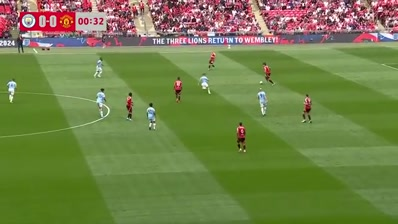

**Top classes**1. **background** — 0.9992. **Offside** — 0.0003. **Indirect free-kick** — 0.0004. **Goal** — 0.0005. **Corner** — 0.000

**Predicted events (±30 frames)**- **Indirect free-kick** @ frame 171 (score 0.955)

In [7]:
VIDEO_TO_VIEW = video_options[0]  # e.g. 'full_match_5fps'
FRAME_NUMBER = 191
TOP_K = DEFAULT_TOP_K
EVENT_WINDOW = DEFAULT_EVENT_WINDOW
SHOW_HIGH_RECALL = False

display_prediction(
    VIDEO_TO_VIEW,
    FRAME_NUMBER,
    top_k=TOP_K,
    event_window=EVENT_WINDOW,
    show_high_recall=SHOW_HIGH_RECALL,
)


## Event search and quick navigation

In [8]:

from collections import Counter

def summarize_events(video):
    events = pred_events.get(video, [])
    by_label = Counter(e['label'] for e in events)
    total = len(events)
    return total, by_label

video = video_options[0]
total, per_label = summarize_events(video)
print(f"Video: {video}")
print(f"Total predicted events: {total}")
for label, count in per_label.most_common():
    print(f" - {label}: {count}")


Video: full_match_5fps
Total predicted events: 68
 - Indirect free-kick: 23
 - Goal: 20
 - Shot off target: 8
 - Offside: 8
 - Card: 4
 - Substitution: 3
 - Penalty kick: 2


In [9]:

def top_events(video, min_score=0.3, limit=10, high_recall=False):
    source = pred_events_high_recall if high_recall else pred_events
    events = [e for e in source.get(video, []) if e['score'] >= min_score]
    events.sort(key=lambda x: x['score'], reverse=True)
    return events[:limit]

VIDEO_FOR_EVENTS = video_options[0]
MIN_SCORE = 0.3
LIMIT = 10
USE_HIGH_RECALL = False

sample_events = top_events(VIDEO_FOR_EVENTS, MIN_SCORE, LIMIT, USE_HIGH_RECALL)
print(f"Top events for {VIDEO_FOR_EVENTS} (min score {MIN_SCORE}): {len(sample_events)} found")
for idx, ev in enumerate(sample_events, 1):
    print(f"{idx}. {ev['label']} @ frame {ev['frame']} — score {ev['score']:.3f}")


Top events for full_match_5fps (min score 0.3): 10 found
1. Indirect free-kick @ frame 5009 — score 0.996
2. Card @ frame 8750 — score 0.994
3. Indirect free-kick @ frame 1621 — score 0.987
4. Goal @ frame 7566 — score 0.985
5. Indirect free-kick @ frame 7420 — score 0.976
6. Offside @ frame 4102 — score 0.968
7. Indirect free-kick @ frame 8152 — score 0.967
8. Shot off target @ frame 11065 — score 0.966
9. Card @ frame 5581 — score 0.964
10. Indirect free-kick @ frame 171 — score 0.955


Jumping to Indirect free-kick @ frame 7420 (score 0.976)


### full_match_5fps — frame 7420 / 11150

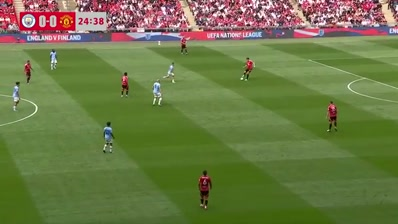

**Top classes**1. **Indirect free-kick** — 0.9762. **background** — 0.0183. **Kick-off** — 0.0064. **Card** — 0.0005. **Shot off target** — 0.000

**Predicted events (±30 frames)**- **Indirect free-kick** @ frame 7420 (score 0.976)

In [14]:

EVENT_INDEX = 5  # 1-based index into sample_events above
TOP_K = DEFAULT_TOP_K
EVENT_WINDOW = DEFAULT_EVENT_WINDOW
SHOW_HIGH_RECALL = False

if not sample_events:
    print("No events found with the current filters.")
else:
    idx = max(1, min(EVENT_INDEX, len(sample_events))) - 1
    event = sample_events[idx]
    print(f"Jumping to {event['label']} @ frame {event['frame']} (score {event['score']:.3f})")
    display_prediction(
        VIDEO_FOR_EVENTS,
        event['frame'],
        top_k=TOP_K,
        event_window=EVENT_WINDOW,
        show_high_recall=SHOW_HIGH_RECALL,
    )
